In [1]:
from __future__ import print_function, division
%matplotlib inline
import statsmodels.formula.api as smf  
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import geopandas as gpd
import os
#import operator
#import requests
import sys
from scipy import stats
from fiona.crs import from_epsg

In [2]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,10)

In [3]:
#nyc open data API, you need apptoken to run this cell
from sodapy import Socrata
client = Socrata("data.cityofnewyork.us", os.getenv("apptoken"))

In [4]:
results = client.get("83x8-shf7",
                     select = "job_type, zip_code, job_start_date, expiration_date, gis_latitude, gis_longitude",
                     limit=4000000)
df = pd.DataFrame.from_records(results)
df.head()

,expiration_date,gis_latitude,gis_longitude,job_start_date,job_type,zip_code
0,09/16/2003,40.644203,-73.892264,07/27/2000,A2,11236
1,11/27/2013,40.682849,-73.947219,01/26/2006,A1,11216
2,10/01/1992,40.763075,-73.969695,11/27/1991,A3,10022
3,07/01/1997,40.756925,-73.972066,03/24/1997,A2,10022
4,03/30/2017,40.747535,-73.986372,09/21/2015,A2,10001


In [5]:
df['expiration_date'] = pd.to_datetime(df['expiration_date'], errors='coerce', format='%m/%d/%Y')
df['job_start_date'] = pd.to_datetime(df['job_start_date'], errors='coerce', format='%m/%d/%Y')

In [6]:
df.shape

(3279416, 6)

In [7]:
df.dtypes

expiration_date    datetime64[ns]
gis_latitude               object
gis_longitude              object
job_start_date     datetime64[ns]
job_type                   object
zip_code                   object
dtype: object

In [8]:
df = df.dropna()

In [9]:
#calculate days of construction
df['job_days'] = df['expiration_date'] - df['job_start_date']
df['job_days'] = df['job_days'].dt.days

In [10]:
df.head()

,expiration_date,gis_latitude,gis_longitude,job_start_date,job_type,zip_code,job_days
0,2003-09-16,40.644203,-73.892264,2000-07-27,A2,11236,1146
1,2013-11-27,40.682849,-73.947219,2006-01-26,A1,11216,2862
2,1992-10-01,40.763075,-73.969695,1991-11-27,A3,10022,309
3,1997-07-01,40.756925,-73.972066,1997-03-24,A2,10022,99
4,2017-03-30,40.747535,-73.986372,2015-09-21,A2,10001,556


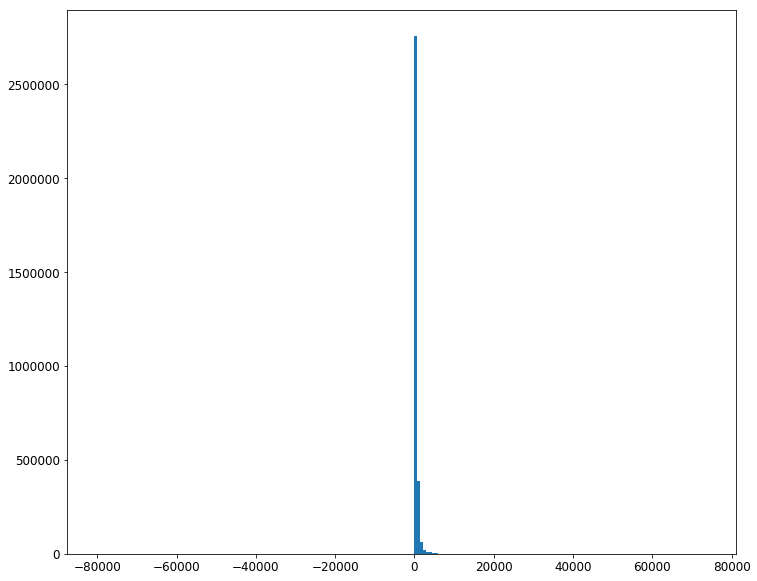

In [11]:
plt.hist(df['job_days'], bins=200)
plt.show()

In [12]:
df['job_days'].describe()

count    3.258129e+06
mean     4.208742e+02
std      7.102354e+02
min     -7.998900e+04
25%      1.960000e+02
50%      3.640000e+02
75%      3.850000e+02
max      7.355100e+04
Name: job_days, dtype: float64

In [13]:
#cases job start day later than expiration day
len(df['job_days'][df['job_days']<0])

2635

In [14]:
#cases last exactly 1 year
len(df[df['job_days']==365])

766816

In [15]:
df = df[df['job_days']>0]
#df = df[df['job_days']<2000]

In [16]:
df = df[df['expiration_date'] > '2015-01-01']
df = df[df['job_start_date'] < '2016-01-01']

In [17]:
df.reset_index(inplace=True)

In [18]:
df.shape

(390595, 8)

In [19]:
df1 = df[df['job_start_date'] < '2015-01-01']
df1['impact_start_date'] = pd.Timestamp('2015-01-01')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
df2 = df[df['job_start_date'] >= '2015-01-01']
df2['impact_start_date'] = df2['job_start_date']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
df1.shape

(211982, 9)

In [22]:
df2.shape

(178613, 9)

In [23]:
df = pd.concat([df1, df2])
df.head()

,index,expiration_date,gis_latitude,gis_longitude,job_start_date,job_type,zip_code,job_days,impact_start_date
1,8,2015-03-11,40.707312,-73.802539,2014-08-04,A2,11432,219,2015-01-01
2,13,2016-02-17,40.710306,-74.006828,2012-02-07,A2,10038,1471,2015-01-01
4,24,2015-03-31,40.746147,-73.994168,2014-04-29,A2,10001,336,2015-01-01
7,44,2015-09-24,40.717267,-74.004863,2014-09-24,A1,10013,365,2015-01-01
8,67,2015-09-02,40.869904,-73.848948,2013-12-23,NB,10469,618,2015-01-01


In [24]:
df1 = df[df['expiration_date'] > '2015-12-31']
df1['impact_end_date'] = pd.Timestamp('2015-12-31')
df2 = df[df['expiration_date'] <= '2015-12-31']
df2['impact_end_date'] = df2['expiration_date']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [25]:
df = pd.concat([df1, df2])
df.head()

,index,expiration_date,gis_latitude,gis_longitude,job_start_date,job_type,zip_code,job_days,impact_start_date,impact_end_date
2,13,2016-02-17,40.710306,-74.006828,2012-02-07,A2,10038,1471,2015-01-01,2015-12-31
13,88,2017-01-19,40.683557,-73.980314,2007-09-20,NB,11217,3409,2015-01-01,2015-12-31
21,156,2017-06-16,40.595665,-73.740348,2005-09-14,NB,11691,4293,2015-01-01,2015-12-31
22,157,2016-02-05,40.706967,-73.947070,2013-12-26,A2,11206,771,2015-01-01,2015-12-31
27,183,2016-07-19,40.735824,-73.746283,2012-08-16,A2,11364,1433,2015-01-01,2015-12-31


In [26]:
#calculate days of impact
df['impact_days'] = df['impact_end_date'] - df['impact_start_date']
df['impact_days'] = df['impact_days'].dt.days

In [27]:
df['impact_days'].describe()

count    390595.000000
mean        199.195824
std         118.569432
min           0.000000
25%          92.000000
50%         192.000000
75%         315.000000
max         364.000000
Name: impact_days, dtype: float64

In [28]:
df.describe()

,index,job_days,impact_days
count,3.905950e+05,390595.000000,390595.000000
mean,1.642759e+06,684.290162,199.195824
std,9.463274e+05,926.140046,118.569432
min,4.000000e+00,1.000000,0.000000
25%,8.219805e+05,346.000000,92.000000
50%,1.643756e+06,365.000000,192.000000
75%,2.463324e+06,745.000000,315.000000
max,3.279403e+06,73551.000000,364.000000


In [29]:
df.shape

(390595, 11)

In [30]:
df.head()

,index,expiration_date,gis_latitude,gis_longitude,job_start_date,job_type,zip_code,job_days,impact_start_date,impact_end_date,impact_days
2,13,2016-02-17,40.710306,-74.006828,2012-02-07,A2,10038,1471,2015-01-01,2015-12-31,364
13,88,2017-01-19,40.683557,-73.980314,2007-09-20,NB,11217,3409,2015-01-01,2015-12-31,364
21,156,2017-06-16,40.595665,-73.740348,2005-09-14,NB,11691,4293,2015-01-01,2015-12-31,364
22,157,2016-02-05,40.706967,-73.947070,2013-12-26,A2,11206,771,2015-01-01,2015-12-31,364
27,183,2016-07-19,40.735824,-73.746283,2012-08-16,A2,11364,1433,2015-01-01,2015-12-31,364


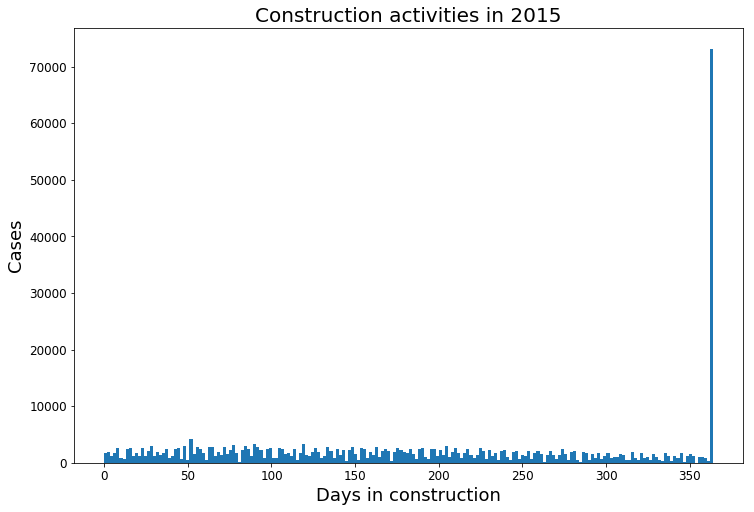

Days of construction activities happening in 2015. Most cases (more than 70,000) covered the whole span of 2015.


In [31]:
fig = plt.figure(figsize=(12,8))
plt.hist(df['impact_days'], bins=200)
plt.title('Construction activities in 2015', fontsize = 20)
plt.xlabel('Days in construction', fontsize = 18)
plt.ylabel('Cases', fontsize = 18)
plt.savefig('construction_activities_2015', dpi=300, transparent=True)
plt.show()
print ('Days of construction activities happening in 2015. ' +
       'Most cases (more than 70,000) covered the whole span of 2015.')

In [32]:
#cases by zip code
dfzip = df.groupby('zip_code').sum()
dfzip.reset_index(inplace=True)
dfzip = dfzip[['zip_code', 'impact_days']]
dfzip.rename(columns={'impact_days': 'total_impact_days'}, inplace=True)
dfzip.head()

,zip_code,total_impact_days
0,00000,41
1,10000,878
2,10001,1526615
3,10002,831002
4,10003,1338875


In [33]:
dfzip.to_csv('DOB_impact_2015_byzipcode.csv')

#### map

In [34]:
os.system("curl -O http://catalog.civicdashboards.com/dataset/11fd957a-8885-42ef-aa49-5c879ec93fac/resource/28377e88-8a50-428f-807c-40ba1f09159b/download/nyc-zip-code-tabulation-areas-polygons.geojson")
os.system("mv " + "nyc-zip-code-tabulation-areas-polygons.geojson " + os.getenv("PUIDATA"))
nyc = gpd.read_file(os.getenv("PUIDATA") + "/" + 'nyc-zip-code-tabulation-areas-polygons.geojson')

In [35]:
nyc['zip_code'] = nyc.postalCode.astype(str)
nyc.drop(['OBJECTID', 'postalCode', 'PO_NAME', 'STATE', 'borough', 'ST_FIPS',
          'CTY_FIPS', 'BLDGpostal', '@id', 'longitude', 'latitude'], axis=1, inplace=True)

In [36]:
mapData = pd.merge(nyc, dfzip, on='zip_code').drop_duplicates('zip_code')
mapData.head()

,geometry,zip_code,total_impact_days
0,POLYGON ((-73.86942457284177 40.74915687096788...,11372,309416
1,POLYGON ((-73.71132911125308 40.74947450816085...,11004,124843
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040,30885
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426,98286
4,"POLYGON ((-73.81088634744756 40.7271718757592,...",11365,314106


In [37]:
mapData.crs = from_epsg(4326) #from lat/long
mapData['geometry'] = nyc.to_crs(epsg=2263).geometry
mapData = gpd.GeoDataFrame(mapData)

In [40]:
mapData = mapData.sort_values(by=['total_impact_days'], ascending=False)
mapData

,geometry,zip_code,total_impact_days
125,"POLYGON ((991606.4029262179 205494.2678669897,...",10013,1693239
112,"POLYGON ((990440.5066359771 215405.07252041, 9...",10011,1654263
224,"POLYGON ((989789.9823464747 214129.9389158244,...",10022,1622561
196,"POLYGON ((990017.0947531497 213302.0045480751,...",10019,1596954
111,"POLYGON ((1063551.44079439 216279.8217551664, ...",10001,1526615
140,"POLYGON ((984793.7954884756 193856.001117324, ...",11201,1502890
113,"POLYGON ((981958.6472873999 213464.5747609858,...",10016,1410318
119,"POLYGON ((1029249.073703725 210099.9768314018,...",10003,1338875
86,"POLYGON ((1012852.721653984 224540.6241311638,...",10023,1271131
103,"POLYGON ((1022299.623363807 218704.0295051604,...",10036,1232341


In [41]:
mapData['total_impact_days'].describe()

count    2.180000e+02
mean     3.543626e+05
std      3.675950e+05
min      1.550000e+02
25%      1.031355e+05
50%      2.500565e+05
75%      4.503508e+05
max      1.693239e+06
Name: total_impact_days, dtype: float64

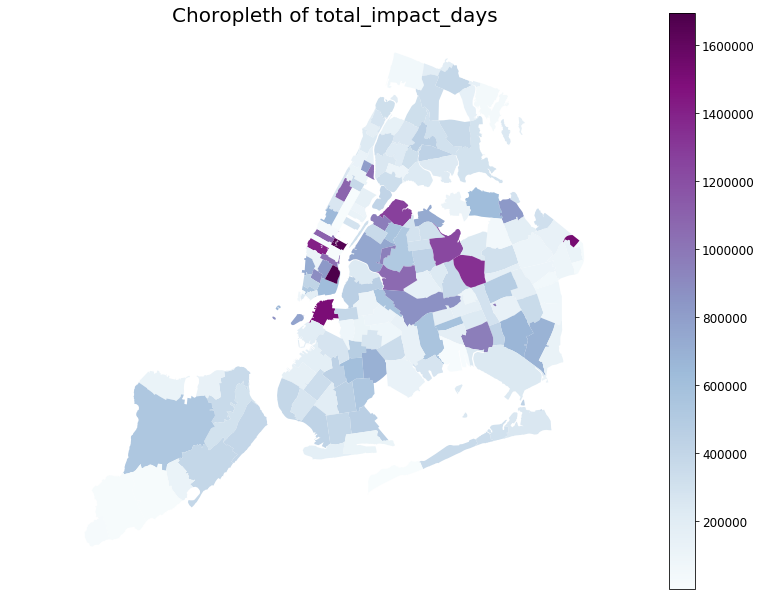

In [38]:
name = 'total_impact_days'
ax = mapData.plot(column='{}'.format(name), cmap='BuPu', alpha=1)
vmin, vmax = min(mapData['{}'.format(name)].values), max(mapData['{}'.format(name)].values)
ax.axis('off')
ax.set_title('Choropleth of {}'.format(name), size=20)
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.savefig('DOB_total_impact_days', dpi=300, transparent=True)
plt.show()